# ++ Carregar dados históricos da Bovespa em Dataframe para análise ++

In [1]:
import time
time.asctime( time.localtime(time.time()) )

'Fri Jun 21 12:04:43 2024'

In [2]:
import pandas as pd
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
# pd.__version__

In [3]:
from IPython.display import FileLink, FileLinks
FileLink('Resultados.ipynb')

C:\Users\F0435280\OneDrive - Banco do Brasil S.A\Área de Trabalho\Alexandre\StockManager-main\Resultados.ipynb

In [4]:
# Setando opção do Pandas para mostrar todas as linhas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Setando separador de milhar
pd.options.display.float_format = '{:,.2f}'.format

In [5]:
from pacote.functions import *

In [6]:
ano = time.localtime().tm_year
if time.localtime().tm_mon < 3:
    str_ano, str_nov_ant, str_dez_ant = f'A{ano}', f'M11{ano-1}', f'M12{ano-1}'
    LISTA_ARQUIVOS = [str_ano, str_nov_ant, str_dez_ant]
else:
    str_ano = f'A{ano}'
    LISTA_ARQUIVOS = [str_ano]

In [7]:
df = carrega_dados(LISTA_ARQUIVOS)

In [8]:
from IPython.display import Markdown, display

# Monday is 0 and Sunday is 6.
dia_semana  = datetime.today().weekday()
ajuste_dias = -3 if dia_semana == 0 else -1
dt_esperado_ult = (datetime.today() + timedelta(days=ajuste_dias)).strftime('%Y-%m-%d')
dt_max = str(df["dtPregao"].max()).split()[0]

if dt_esperado_ult == dt_max:
    font_color="alert-success"
    a = "Atualizado!"
else:
    font_color="alert-danger"
    a = "Desatualizado!!! Última data " + str(dt_max)
def printmd(string):
    display(Markdown(string))

In [9]:
#  df_n_dias | vol | col_pc | pc_min | avg_vr_fech
parm_vol = 6000000

d25 = monta_tabela(monta_df_periodos(df, 25), parm_vol, '1.0%', 22, 1)
d20 = monta_tabela(monta_df_periodos(df, 20), parm_vol, '1.0%', 18, 1)
d15 = monta_tabela(monta_df_periodos(df, 15), parm_vol, '1.0%', 14, 1)
d10 = monta_tabela(monta_df_periodos(df, 10), parm_vol, '1.0%', 10, 1)
d05 = monta_tabela(monta_df_periodos(df, 5), parm_vol, '1.0%', 5, 1)
d04 = monta_tabela(monta_df_periodos(df, 4), parm_vol, '1.0%', 4, 1)
d03 = monta_tabela(monta_df_periodos(df, 3), parm_vol, '1.0%', 3, 1)
merge1 = pd.merge(d25['cdAcao'], d20['cdAcao'], how ='inner', on =['cdAcao'])
merge2 = pd.merge(merge1, d15['cdAcao'], how ='inner', on =['cdAcao'])
merge3 = pd.merge(merge2, d10['cdAcao'], how ='inner', on =['cdAcao'])
merge_final = pd.merge(merge3, d05['cdAcao'], how ='inner', on =['cdAcao'])

In [10]:
printmd(f'**<div class={font_color}>Arquivo {a}</div>**')

**<div class=alert-success>Arquivo Atualizado!</div>**

### 25 dias, order by 1%

In [11]:
d25

,cdAcao,0.5%,1.0%,1.5%,2.0%,2.5%,3.0%,AvgVol,AvgVrFech,AvgPcAbert
758,DASA3,23,22,20,20,20,18,"10,416,356.12",3.81,0.88
1691,QUAL3,24,22,19,18,10,9,"7,769,254.84",1.65,0.14


### 20 dias, order by 1%

In [12]:
d20

,cdAcao,0.5%,1.0%,1.5%,2.0%,2.5%,3.0%,AvgVol,AvgVrFech,AvgPcAbert
744,DASA3,19,19,18,18,18,16,"11,997,935.45",3.89,1.14
1663,QUAL3,20,19,17,16,9,8,"7,645,217.95",1.64,0.26
1502,NVDC34,18,18,15,13,12,10,"131,429,016.55",74.77,-3.34
909,EZTC3,19,18,11,7,5,5,"22,074,651.20",13.08,0.24


### 15 dias, order by 1%

In [13]:
d15

,cdAcao,0.5%,1.0%,1.5%,2.0%,2.5%,3.0%,AvgVol,AvgVrFech,AvgPcAbert
730,DASA3,14,14,13,13,13,12,"14,149,960.87",3.87,1.49
1630,QUAL3,15,14,12,11,8,7,"8,697,759.20",1.64,0.19
890,EZTC3,14,14,10,6,5,5,"22,828,618.07",13.12,0.19


### 10 dias, order by 1%

In [14]:
d10

,cdAcao,0.5%,1.0%,1.5%,2.0%,2.5%,3.0%,AvgVol,AvgVrFech,AvgPcAbert
157,AZEV4,10,10,10,8,8,8,"6,667,045.40",1.24,1.12


### 5 dias, order by 1%

In [15]:
d05

,cdAcao,0.5%,1.0%,1.5%,2.0%,2.5%,3.0%,AvgVol,AvgVrFech,AvgPcAbert
148,AZEV4,5,5,5,4,4,4,"8,496,983.80",1.29,2.25
1713,STBP3,5,5,5,4,4,4,"52,884,759.00",12.34,-0.01
1699,SOMA3,5,5,4,4,4,0,"62,827,792.20",5.86,0.21
529,CLSA3,5,5,4,4,3,2,"9,751,639.00",7.01,-0.31
1335,NVDC34,5,5,4,3,3,2,"151,256,679.83",15.14,0.87
104,AMBP3,5,5,4,3,2,2,"10,703,354.60",8.76,-0.21
1683,SMTO3,5,5,3,3,3,3,"68,784,601.80",31.48,-0.02
1034,INBR32,5,5,3,2,2,2,"62,755,134.32",31.06,-0.05
1396,PCAR3,5,5,3,2,2,1,"36,934,909.40",2.97,0.14
124,ARZZ3,5,5,3,2,2,0,"114,460,317.20",50.11,0.43


In [16]:
d04

,cdAcao,0.5%,1.0%,1.5%,2.0%,2.5%,3.0%,AvgVol,AvgVrFech,AvgPcAbert
146,AZEV4,4,4,4,3,3,3,"10,213,434.00",1.31,3.02
1664,STBP3,4,4,4,3,3,3,"53,765,480.00",12.48,0.18
1634,SMTO3,4,4,3,3,3,3,"64,405,109.75",31.66,0.11
1650,SOMA3,4,4,3,3,3,0,"67,393,931.50",5.85,0.43
513,CLSA3,4,4,3,3,2,1,"9,290,141.75",6.99,-0.50
102,AMBP3,4,4,3,2,2,2,"11,615,923.25",8.84,-0.26
1295,NVDC34,4,4,3,2,2,2,"163,080,119.22",15.21,1.05
1005,INBR32,4,4,2,1,1,1,"64,915,043.64",31.06,0.07
1354,PCAR3,4,4,2,1,1,1,"32,547,625.75",2.95,0.17
122,ARZZ3,4,4,2,1,1,0,"118,504,660.25",50.08,0.59


In [17]:
d03

,cdAcao,0.5%,1.0%,1.5%,2.0%,2.5%,3.0%,AvgVol,AvgVrFech,AvgPcAbert
140,AZEV4,3,3,3,3,3,3,"12,673,383.67",1.37,4.30
212,BEEF3,3,3,3,3,3,3,"48,224,397.00",6.45,0.09
1175,MRFG3,3,3,3,3,3,3,"84,974,205.00",10.86,0.15
1411,RAPT4,3,3,3,3,3,3,"28,924,556.00",9.53,0.99
1574,SMTO3,3,3,3,3,3,3,"66,781,801.33",31.83,0.32
1604,STBP3,3,3,3,3,3,3,"47,947,962.33",12.68,0.24
1590,SOMA3,3,3,3,3,3,0,"78,484,767.33",5.83,0.69
362,BRFS3,3,3,3,3,2,2,"224,201,882.00",19.84,0.12
1272,ONCO3,3,3,3,3,2,2,"30,418,644.33",5.82,0.44
493,CLSA3,3,3,3,3,2,1,"8,193,543.33",6.99,0.19


In [18]:
printmd(f'**<div class={font_color}>Status {a}</div>**')

**<div class=alert-success>Status Atualizado!</div>**

### Consulta ação específica

In [35]:
consulta_acao_formatada(df, "AZEV4")[:-1]

,cdAcao,dtPregao,vrFech,vrVolume,vrMaxDia,vrMinDia,vrAbert,pcVar,pcMaxDia,pcMinDia,pcAbert,ic05,ic10,ic15,ic20,ic25,ic30
196104,AZEV4,2024-06-20,1.36,"9,433,587",1.55,1.33,1.48,-6.21%,6.90%,-8.28%,2.07%,1,1,1,1,1,1
194415,AZEV4,2024-06-19,1.45,"18,686,337",1.51,1.35,1.35,12.40%,17.05%,4.65%,4.65%,1,1,1,1,1,1
192731,AZEV4,2024-06-18,1.29,"9,900,227",1.34,1.17,1.20,14.16%,18.58%,3.54%,6.19%,1,1,1,1,1,1
191106,AZEV4,2024-06-17,1.13,"2,833,585",1.22,1.13,1.19,-5.83%,1.67%,-5.83%,-0.83%,1,1,1,,,
189583,AZEV4,2024-06-14,1.20,"1,631,183",1.25,1.19,1.20,-0.83%,3.31%,-1.65%,-0.83%,1,1,1,1,1,1
187791,AZEV4,2024-06-13,1.21,"3,253,298",1.25,1.18,1.23,-1.63%,1.63%,-4.07%,0,1,1,1,,,
186209,AZEV4,2024-06-12,1.23,"3,497,053",1.28,1.21,1.22,2.50%,6.67%,0.83%,1.67%,1,1,1,1,1,1
184597,AZEV4,2024-06-11,1.20,"2,838,977",1.24,1.18,1.19,0.84%,4.20%,-0.84%,0,1,1,1,1,1,1
182755,AZEV4,2024-06-10,1.19,"4,930,285",1.23,1.15,1.19,0,3.36%,-3.36%,0,1,1,1,1,1,1
181050,AZEV4,2024-06-07,1.19,"9,665,922",1.21,1.13,1.14,2.59%,4.31%,-2.59%,-1.72%,1,1,1,1,1,1


### Ações presentes em todos os períodos

In [20]:
merge_final

,cdAcao


### Grandes Variações de Volume

In [21]:
teste = verifica_mudanca_vol(df, data="max")
teste["pcVar_y"] = pd.to_numeric(teste["pcVar_y"].replace({"%":""}, regex=True))
teste = teste.sort_values(["pcVar_y", "vrVolume_y"], ascending=False)
teste['pcVar_y'] = teste['pcVar_y'].apply(lambda x: x * 0.01)
teste['pcVar_y'] = teste['pcVar_y'].map('{:.2%}'.format)
teste

,cdAcao,dtPregao_x,vrVolume_x,pcVar_x,vrFech_x,vrVolume_y,pcVar_y,vrFech_y,dtPregao_y
1017,POMO4,2024-06-19,"16,172,009.00",1.01%,6.00,"66,126,407.00",6.17%,6.37,2024-06-20
1100,RECV3,2024-06-19,"23,775,945.00",1.87%,17.93,"83,950,984.00",4.85%,18.80,2024-06-20
1123,ROXO34,2024-06-19,"8,731,630.55",-1.33%,10.42,"87,238,060.15",4.70%,10.91,2024-06-20
1418,XPBR31,2024-06-19,"22,993,606.84",-0.67%,93.68,"93,116,744.31",4.21%,97.62,2024-06-20
324,CCRO3,2024-06-19,"63,794,661.00",1.75%,11.63,"193,330,885.00",2.49%,11.92,2024-06-20
979,PCAR3,2024-06-19,"13,598,920.00",1.03%,2.95,"48,889,130.00",1.69%,3.00,2024-06-20
1338,VAMO3,2024-06-19,"17,887,956.00",2.39%,7.28,"56,139,382.00",1.65%,7.40,2024-06-20
422,CURY3,2024-06-19,"12,300,511.00",-0.05%,18.69,"41,772,593.00",1.07%,18.89,2024-06-20
628,GOGL34,2024-06-19,"3,743,508.90",0.57%,79.59,"14,017,191.11",0.93%,80.33,2024-06-20
590,FRAS3,2024-06-19,"1,547,368.00",1.33%,17.48,"7,598,686.00",0.69%,17.60,2024-06-20


In [22]:
list_datas, d05_count, d10_count, d15_count, d20_count, d25_count = [], [], [], [], [], []
df_temp = df.copy()
d05_temp = d05.copy()
d10_temp = d10.copy()
d15_temp = d15.copy()
d20_temp = d20.copy()
d25_temp = d25.copy()

for i in range(0, 30):
    dt_max = df_temp["dtPregao"].max()
#     print(str(dt_max)[0:10])
    
    list_datas.append(str(dt_max)[0:10])
    d05_count.append(len(d05_temp))
    d10_count.append(len(d10_temp))
    d15_count.append(len(d15_temp))
    d20_count.append(len(d20_temp))
    d25_count.append(len(d25_temp))
    
    df_temp = df_temp.loc[df_temp["dtPregao"] != dt_max]
    d05_temp = monta_tabela(monta_df_periodos(df_temp, 5), 3000000, '1.0%', 5, 1)
    d10_temp = monta_tabela(monta_df_periodos(df_temp, 10), 3000000, '1.0%', 9, 1)
    d15_temp = monta_tabela(monta_df_periodos(df_temp, 15), 3000000, '1.0%', 14, 1)
    d20_temp = monta_tabela(monta_df_periodos(df_temp, 20), 3000000, '1.0%', 18, 1)
    d25_temp = monta_tabela(monta_df_periodos(df_temp, 25), 3000000, '1.0%', 22, 1)

In [23]:
print(d05_count)
print(d10_count)
print(d15_count)
print(d20_count)
print(d25_count)

[10, 5, 10, 10, 17, 11, 12, 9, 9, 10, 14, 11, 12, 18, 14, 12, 16, 12, 10, 8, 6, 21, 25, 25, 32, 13, 8, 7, 11, 13]
[1, 10, 11, 8, 9, 8, 7, 5, 6, 11, 16, 8, 6, 8, 5, 7, 13, 12, 8, 8, 9, 9, 11, 11, 15, 19, 9, 8, 11, 13]
[3, 4, 4, 3, 4, 3, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 1, 1, 2, 2, 3, 6, 7, 5, 2, 2, 1, 1, 4]
[4, 3, 2, 2, 2, 2, 3, 3, 2, 2, 2, 1, 1, 2, 2, 3, 1, 0, 1, 1, 0, 2, 2, 4, 4, 7, 7, 3, 1, 3]
[2, 2, 2, 2, 3, 2, 2, 2, 1, 2, 3, 1, 1, 2, 1, 0, 1, 1, 1, 1, 2, 5, 4, 3, 3, 3, 3, 3, 3, 4]


In [24]:
def gera_grafico(list_datas, count):
    fig, ax = plt.subplots(1, figsize = (20, 3))
    ax.grid()
    fig.autofmt_xdate()
    plt.plot(list(reversed(list_datas)), list(reversed(count)))
    plt.show()

### Gráfico 05

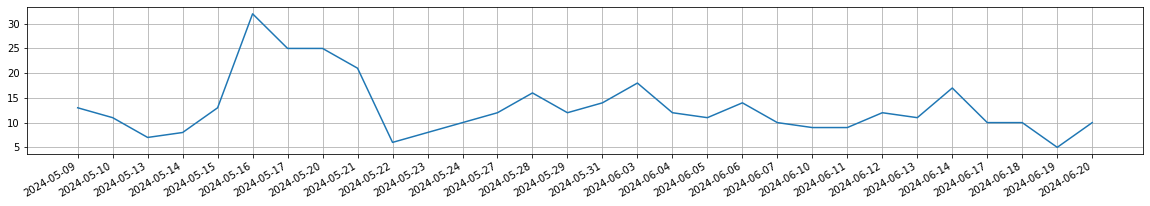

In [25]:
gera_grafico(list_datas, d05_count)

### Gráfico 10

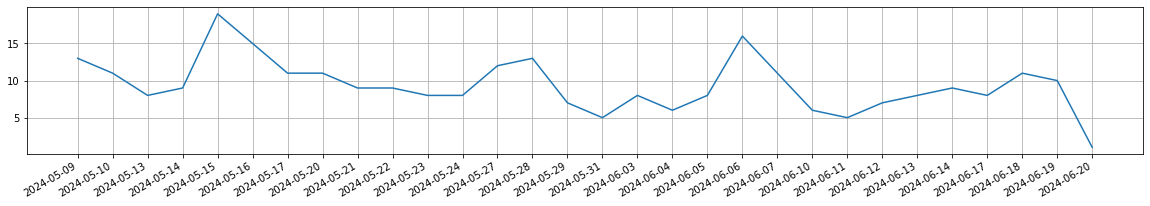

In [26]:
gera_grafico(list_datas, d10_count)

### Gráfico 15

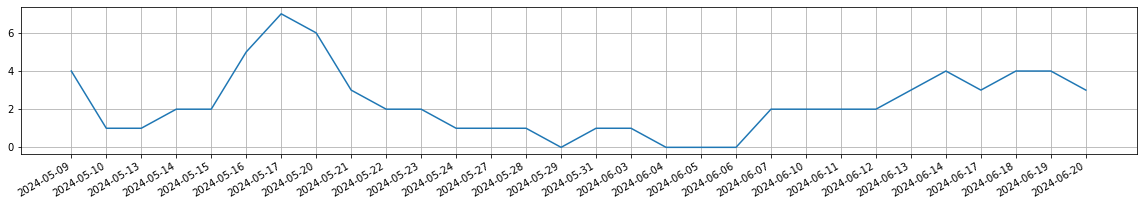

In [27]:
gera_grafico(list_datas, d15_count)

### Gráfico 20

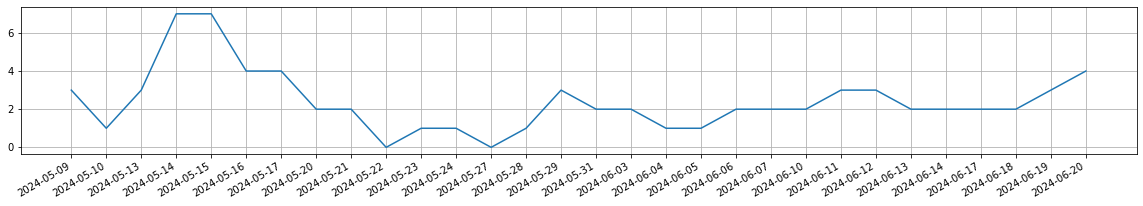

In [28]:
gera_grafico(list_datas, d20_count)

### Gráfico 25

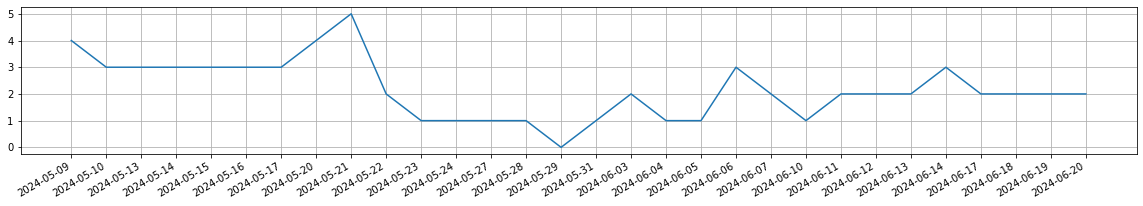

In [29]:
gera_grafico(list_datas, d25_count)

### ======================================== TESTES ========================================

In [30]:
bla

NameError: name 'bla' is not defined

### Comparar Maiores Lucros

In [ ]:
df_original = df.copy()

In [ ]:
df = df_original.copy()

In [ ]:
df_teste = df_original.copy()

In [ ]:
dt_max = df_teste["dtPregao"].max()
df_teste = df_teste.loc[df_teste["dtPregao"] != dt_max]

In [ ]:
d05 = monta_tabela(monta_df_periodos(df_teste, 5), 3000000, '1.0%', 5, 2)
d05

In [ ]:
consulta_acao(df_teste, "RAIZ4")

### ----------------------------------------------------------------------------

In [ ]:
df_1 = monta_lucro_periodo(df, 10, 0, True)
df_2 = monta_lucro_periodo(df, 10, 1, True)

In [ ]:
df_final = df_1.copy()
df_final['posicao ant'], df_final['mudanca'] = [
    df_2['posicao']
    , df_2['posicao'] - df_1['posicao']
]
df_final['posicao ant'] = df_final['posicao ant'].fillna(0).astype('int')
df_final['mudanca'] = df_final['mudanca'].fillna(0).astype('int')

In [ ]:
df_final.sort_values(["mudanca"], ascending=False)

In [ ]:
df_final.sort_values(["mudanca"], ascending=False).loc[df_final['posicao ant'] <= 10]

In [ ]:
df_1

In [ ]:
df_2

In [ ]:
# dfDtMin = df5d.loc[(df["dtPregao"] == dt_min_5d) & (df["cdAcao"] == 'PTBL3')]

df5d  = busca_periodos(df, 5)
df25d = busca_periodos(df, 25)

dt_min_5d  = df5d["dtPregao"].min()
dt_min_25d = df25d["dtPregao"].min()
dt_max     = df5d["dtPregao"].max()
dfDtMin5d  = df5d.loc[(df5d["dtPregao"] == dt_min_5d)].set_index(["cdAcao"])
dfDtMin25d = df25d.loc[(df25d["dtPregao"] == dt_min_25d)].set_index(["cdAcao"])
dfDtMax    = df5d.loc[(df5d["dtPregao"] == dt_max)].set_index(["cdAcao"])
dfAvgVol5d  = busca_media(df5d, "vrVolume", "vol").set_index(["cdAcao"])
dfAvgVol25d = busca_media(df25d, "vrVolume", "vol").set_index(["cdAcao"])

In [ ]:
 dfPc5d = pd.DataFrame({
         "dtInicio":dfDtMin5d["dtPregao"] ,"dtFim":dfDtMax["dtPregao"]
        ,"vrInicio":dfDtMin5d["vrFech"]   ,"vrFim":dfDtMax["vrFech"]
        ,"pcPeriodo":((dfDtMax["vrFech"] - dfDtMin5d["vrFech"]) / dfDtMin5d["vrFech"]) * 100
        ,"avgVol":dfAvgVol5d["vol"]
    })

In [ ]:
 dfPc25d = pd.DataFrame({
         "dtInicio":dfDtMin25d["dtPregao"] ,"dtFim":dfDtMax["dtPregao"]
        ,"vrInicio":dfDtMin25d["vrFech"]   ,"vrFim":dfDtMax["vrFech"]
        ,"pcPeriodo":((dfDtMax["vrFech"] - dfDtMin25d["vrFech"]) / dfDtMin25d["vrFech"]) * 100
        ,"avgVol":dfAvgVol25d["vol"]
    })

In [ ]:
# dfPc25d.sort_values(["pcPeriodo"], ascending=False).loc[(dfPc25d["avgVol"] > 6000000)]

In [ ]:
# dfPc5d.sort_values(["pcPeriodo"], ascending=False).loc[(dfPc5d["avgVol"] > 6000000)]

In [ ]:
# dfPc25d['pcPeriodo']

In [ ]:
df_temp = monta_lucro_periodo(df, 25, 0, True)
# monta_lucro_periodo(df, 25, 0)

In [ ]:
# df_temp

In [ ]:
df_n_dias = busca_periodos(df, 26)

dias_ant = 2
i = 0
while i <= dias_ant:
    dt_max  = df_n_dias["dtPregao"].max()
    df_n_dias = df_n_dias.loc[df_n_dias["dtPregao"] != dt_max]
    i += 1
    
dt_max

In [ ]:
### 25 dias, Order by 0.5% # df05.loc[(df05["AvgVol"] > 6000000) & (df05["0.5%"] >= 23) & (df05["AvgVrFech"] > 5)].sort_values(["0.5%", "1.0%", "1.5%", "2.0%"], ascending=False)
### 20 dias, Order by 0.5% # df05_20d.loc[(df05_20d["AvgVol"] > 6000000) & (df05_20d["0.5%"] >= 19) & (df05_20d["AvgVrFech"] > 5)].sort_values(["0.5%", "1.0%", "1.5%", "2.0%"], ascending=False)
### 15 dias, Order by 0.5% # df05_15d.loc[(df05_15d["AvgVol"] > 6000000) & (df05_15d["0.5%"] >= 15) & (df05_15d["AvgVrFech"] > 5)].sort_values(["0.5%", "1.0%", "1.5%", "2.0%"], ascending=False)

## Definindo valores para compra

In [ ]:
# Valor disponível para cmp / 1000
# Valor da ação no leilão
vr_corretagem = 9.8
emolumentos = 0.000325
acao = 'LIGT3'
vr_disp = 110
vr_acao_leilao = 1148 / 100
vr_qtd = round((vr_disp * 1000) / (vr_acao_leilao * 100)) * 100

In [ ]:
vr_cmp = round(vr_acao_leilao * 1.014, 2)

vr_tot_cmp = vr_acao_leilao * vr_qtd
corret_cmp = vr_corretagem + (vr_tot_cmp * emolumentos)
vr_tot_liq_cmp = vr_tot_cmp + corret_cmp

vr_acao_vnd_10 = float('{0:.2f}'.format(vr_acao_leilao * 1.0108 + 0.01))
vr_tot_vnd_10 = vr_acao_vnd_10 * vr_qtd
corret_vnd_10 = vr_corretagem + (vr_tot_vnd_10 * emolumentos)
vr_tot_liq_vnd_10 = vr_tot_vnd_10 - corret_vnd_10

vr_acao_vnd_15 = float('{0:.2f}'.format(vr_acao_leilao * 1.0158 + 0.01))
vr_tot_vnd_15 = vr_acao_vnd_15 * vr_qtd
corret_vnd_15 = vr_corretagem + (vr_tot_vnd_15 * emolumentos)
vr_tot_liq_vnd_15 = vr_tot_vnd_15 - corret_vnd_15

In [ ]:
d = {'Compra':     ['Quantidade', 'Valor Leilão', 'Total', 'Total líquido', 'Corretagem Compra'],
     ' ':          [vr_qtd, vr_acao_leilao, vr_tot_cmp, vr_tot_liq_cmp, corret_cmp],
     'Venda 1,0%': ['Valor compra', 'Valor', 'Total', 'Total líquido', 'Corretagem Venda'],
     '1,0%':       [vr_cmp, vr_acao_vnd_10, vr_tot_vnd_10, vr_tot_liq_vnd_10, corret_vnd_10],
     'Venda 1,5%': [' ', 'Valor', 'Total', 'Total líquido', 'Corretagem Venda'],
     '1,5%':       [' ', vr_acao_vnd_15, vr_tot_vnd_15, vr_tot_liq_vnd_15, corret_vnd_15]
    }
df_calc = pd.DataFrame(data=d)
df_calc

In [ ]:
d2 = {'Index':      ['Quantidade', 'Valor', 'Total', 'Total líquido', 'Corretagem'],
      'Compra':     [vr_qtd, vr_cmp, vr_tot_cmp, vr_tot_liq_cmp, corret_cmp],
      'Venda 1.0%': [vr_qtd, vr_acao_vnd_10, vr_tot_vnd_10, vr_tot_liq_vnd_10, corret_vnd_10],
      'Venda 1.5%': [vr_qtd, vr_acao_vnd_15, vr_tot_vnd_15, vr_tot_liq_vnd_15, corret_vnd_15]
     }
df_calc2 = pd.DataFrame(data=d2)
df_calc2.set_index('Index')
df_calc2

In [ ]:
time.asctime( time.localtime(time.time()) )